# Using Text Data (Pet Descriptions)
Below, we run a Text Only model as well as a Text model unioned with our numerical model.

In [1]:
# Change this depending on where notebook is running
import os
os.chdir('..')

data_loc = "data/"

In [2]:
import numpy as np
import pandas as pd
from glob import glob
import json
import matplotlib.pyplot as plt

import data
from model import *

Using TensorFlow backend.


In [3]:
# Define data locations
train_images = data_loc + "train_images/*"
test_images = data_loc + "test_images/*"

breed_labels_file = data_loc + "breed_labels.csv"
state_labels_file = data_loc + "state_labels.csv"
color_labels_file = data_loc + "color_labels.csv"

train_file = data_loc + "train/train.csv"
test_file = data_loc + "test/test.csv"

train_sentiment_location = data_loc + "train_sentiment"
test_sentiment_location = data_loc + "test_sentiment"

In [4]:
breed_labels = pd.read_csv(breed_labels_file)
state_labels = pd.read_csv(state_labels_file)
color_labels = pd.read_csv(color_labels_file)
train_df = pd.read_csv(train_file)
test_df = pd.read_csv(test_file)

### Text Parsing

#### Process sentiment metadata
If the data has already been pre-processed, it will be read from disk.

In [5]:
preprocessed_file = "sentiment_parsed.csv"
if len(glob(preprocessed_file)) == 0:
    data.get_sentiment(train_df, train_sentiment_location)
else:
    sentiment = pd.read_csv(preprocessed_file)
    train_df = train_df.merge(sentiment, on='PetID')

preprocessed_file = "test_sentiment_parsed.csv"
if len(glob(preprocessed_file)) == 0:
    data.get_sentiment(test_df, test_sentiment_location)
else:
    sentiment = pd.read_csv(preprocessed_file)
    test_df = test_df.merge(sentiment, on='PetID')

#### Parse Description

In [6]:
train_sequence, test_sequence, vocab_len = data.parse_description(train_df, test_df)

In [7]:
train_df['Sequence'] = train_sequence
test_df['Sequence'] = test_sequence

In [8]:
display(train_df[['Sequence']][:10])

,Sequence
0,"[6735, 17276, 24622, 23174, 11178, 25075, 8465..."
1,"[6462, 12559, 18919, 10091, 24534, 24521, 1256..."
2,"[7315, 10091, 11832, 24726, 14221, 16214, 1544..."
3,"[4540, 19930, 15042, 19503, 8767, 24879, 4540,..."
4,"[23158, 11178, 18848, 12176, 3270, 23588, 1354..."
5,"[11523, 18130, 21259, 6867, 1820, 18432, 0, 0,..."
6,"[8467, 18723, 1841, 4587, 21295, 22829, 17462,..."
7,"[16214, 15441, 3270, 18723, 20174, 455, 23264,..."
8,"[8091, 19503, 13438, 18130, 6462, 10699, 18780..."
9,"[7154, 18965, 11523, 6462, 14273, 3845, 11699,..."


### Preprocess Numeric Data - One hot encoding

In [9]:
# One hot encode columns
for col, num_class in data.one_hot_cols.items():
    if col is not 'Breed1' and col is not 'Breed2':
        encode = data.one_hot_encode(train_df, col, num_class, inplace=True)
        encode = data.one_hot_encode(test_df, col, num_class, inplace=True)
        print("One hot encoding {} with {} classes...".format(col, num_class))

One hot encoding Type with 2 classes...
One hot encoding Gender with 3 classes...
One hot encoding Color1 with 7 classes...
One hot encoding Color2 with 7 classes...
One hot encoding Color3 with 7 classes...
One hot encoding MaturitySize with 5 classes...
One hot encoding FurLength with 4 classes...
One hot encoding Vaccinated with 3 classes...
One hot encoding Dewormed with 3 classes...
One hot encoding Sterilized with 3 classes...
One hot encoding Health with 4 classes...
One hot encoding State with 15 classes...


In [10]:
# One hot encode y-output
encode = data.one_hot_encode(train_df, 'AdoptionSpeed', inplace=True)

In [11]:
y_col = ['AdoptionSpeed_0', 'AdoptionSpeed_1', 'AdoptionSpeed_2', 'AdoptionSpeed_3', 'AdoptionSpeed_4']

In [12]:
numeric_cols = list(train_df.columns)
numeric_cols.remove("PetID") # String
numeric_cols.remove("Name") # String
numeric_cols.remove("RescuerID") # String
numeric_cols.remove("Description") # String, processed seperately
numeric_cols.remove("Sequence") # processed seperately

for col in y_col:
    numeric_cols.remove(col)

In [13]:
# Testing columns to remove
numeric_cols.remove('Breed1')
numeric_cols.remove('Breed2')

In [14]:
print(numeric_cols)

['Type', 'Age', 'Quantity', 'Fee', 'VideoAmt', 'PhotoAmt', 'SentimentMagnitude', 'SentimentScore', 'NumSentences', 'Gender_1', 'Gender_2', 'Gender_3', 'Color1_1', 'Color1_2', 'Color1_3', 'Color1_4', 'Color1_5', 'Color1_6', 'Color1_7', 'Color2_0', 'Color2_2', 'Color2_3', 'Color2_4', 'Color2_5', 'Color2_6', 'Color2_7', 'Color3_0', 'Color3_3', 'Color3_4', 'Color3_5', 'Color3_6', 'Color3_7', 'MaturitySize_1', 'MaturitySize_2', 'MaturitySize_3', 'MaturitySize_4', 'FurLength_1', 'FurLength_2', 'FurLength_3', 'Vaccinated_1', 'Vaccinated_2', 'Vaccinated_3', 'Dewormed_1', 'Dewormed_2', 'Dewormed_3', 'Sterilized_1', 'Sterilized_2', 'Sterilized_3', 'Health_1', 'Health_2', 'Health_3', 'State_41324', 'State_41325', 'State_41326', 'State_41327', 'State_41330', 'State_41332', 'State_41335', 'State_41336', 'State_41342', 'State_41345', 'State_41361', 'State_41367', 'State_41401', 'State_41415']


In [41]:
# Drop any nans
train_df.dropna(inplace=True)
test_df.dropna(inplace=True)

In [42]:
# normalize numeric columns
df = train_df[numeric_cols]
train_df[numeric_cols] = (df - df.min()) / (df.max() - df.min())

### Split into train and validation sets

In [43]:
text_cols = 'Sequence'

In [44]:
# Create a mask for training and validation data
msk = np.random.rand(len(train_df)) < 0.8

In [45]:
print("Let total:", len(train_df))
print("Len train:" , len(train_df[msk]))
print("Len valid:", len(train_df[~msk]))

Let total: 13215
Len train: 10514
Len valid: 2701


Split into training and validation data


In [46]:
# Text Data
train_x_text = train_df[text_cols][msk]
train_x_text = pd.DataFrame([row for row in train_x_text]) # To make this correct shape

valid_x_text = train_df[text_cols][~msk]
valid_x_text = pd.DataFrame([row for row in valid_x_text])

print("Train x shape {}".format(train_x_text.shape))
print("Valid x shape {}".format(valid_x_text.shape))

Train x shape (10514, 30)
Valid x shape (2701, 30)


In [47]:
# Numeric
train_x_num = train_df[numeric_cols][msk]
valid_x_num = train_df[numeric_cols][~msk]

print("Train x shape {}".format(train_x_num.shape))
print("Valid x shape {}".format(valid_x_num.shape))

Train x shape (10514, 65)
Valid x shape (2701, 65)


In [48]:
# The y's are the same for both text and numerical models
train_y = train_df[y_col][msk]
valid_y = valid_y_num = train_df[y_col][~msk]

In [49]:
print(train_x_num.describe())

               Type           Age      Quantity           Fee      VideoAmt  \
count  10514.000000  10514.000000  10514.000000  10514.000000  10514.000000   
mean       0.563249      0.042251      0.026426      0.007444      0.007383   
std        0.496007      0.072987      0.073230      0.026011      0.044499   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.007843      0.000000      0.000000      0.000000   
50%        1.000000      0.011765      0.000000      0.000000      0.000000   
75%        1.000000      0.047059      0.000000      0.000000      0.000000   
max        1.000000      1.000000      1.000000      0.666667      1.000000   

           PhotoAmt  SentimentMagnitude  SentimentScore  NumSentences  \
count  10514.000000        10514.000000    10514.000000  10514.000000   
mean       0.132740            0.069049        0.658413      0.051448   
std        0.120531            0.065844        0.151838      0.060236

## Text Only Model
Defined in model.py as TextOnlyModel

In [50]:
text_model = TextOnlyModel((train_x_text, train_y),
                           (valid_x_text, valid_y),
                           vocab_len)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
description_encoder (Sequent (None, 32)                829088    
_________________________________________________________________
dense_16 (Dense)             (None, 5)                 165       
Total params: 829,253
Trainable params: 829,253
Non-trainable params: 0
_________________________________________________________________


In [25]:
text_model.compile()
text_model.train(epochs=10)

Train on 12051 samples, validate on 2942 samples
Epoch 1/10
12051/12051 [==============================] - 42s 4ms/step - loss: 1.4721 - acc: 0.2814 - val_loss: 1.4849 - val_acc: 0.2750
Epoch 2/10
12051/12051 [==============================] - 36s 3ms/step - loss: 1.4206 - acc: 0.3436 - val_loss: 1.4476 - val_acc: 0.3219
Epoch 3/10
12051/12051 [==============================] - 36s 3ms/step - loss: 1.3004 - acc: 0.4220 - val_loss: 1.4998 - val_acc: 0.3294
Epoch 4/10
12051/12051 [==============================] - 37s 3ms/step - loss: 1.1895 - acc: 0.4800 - val_loss: 1.5634 - val_acc: 0.3382
Epoch 5/10
12051/12051 [==============================] - 36s 3ms/step - loss: 1.0948 - acc: 0.5254 - val_loss: 1.6185 - val_acc: 0.3409
Epoch 6/10
12051/12051 [==============================] - 47s 4ms/step - loss: 1.0032 - acc: 0.5633 - val_loss: 1.6942 - val_acc: 0.3341
Epoch 7/10
12051/12051 [==============================] - 36s 3ms/step - loss: 0.9298 - acc: 0.6076 - val_loss: 1.8021 - val_acc:

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


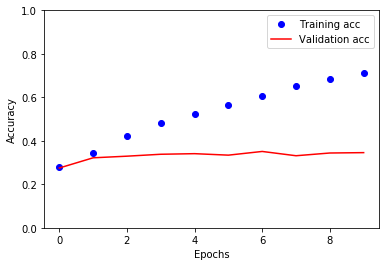

In [26]:
history = text_model.model.history
print(history.history.keys())

acc = history.history['acc']
val_acc = history.history['val_acc']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.legend()
plt.show()

## Numerical Model

In [84]:
class ImageFreeModel(KaggleModel):
    def __init__(self, train, test, shape):
        kernel = Sequential(name='image_free_encoder')
        
        kernel.add(BatchNormalization(input_shape=(shape,)))
        
        kernel.add(Dense(128))
        kernel.add(Activation('relu'))
        
        kernel.add(Dense(64, activation='relu'))
        
        kernel.add(Dense(32, activation='relu'))

        
        # Use a single dense residual block
        """
        blk = Sequential()
        
        blk.add(Dropout(0.5, input_shape=kernel.output_shape[1:]))
        blk.add(Dense(128))
        blk.add(Activation('relu'))

        blk.add(Dense(128))
        blk.add(Activation('relu'))

        kernel.add(ResidualBlock(blk))
        """

        model = Sequential(name='image_free')
        model.add(kernel)
        
        # Labels are one of [0, 1, 2, 3, 4]
        model.add(Dense(5, activation='softmax'))

        # Build using the built model
        super().__init__(model, train, test)

    def compile(self):
        self.model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [85]:
numerical_model = ImageFreeModel((train_x_num, train_y),
                                 (valid_x_num, valid_y),
                                 train_x_num.shape[1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_free_encoder (Sequenti (None, 32)                19044     
_________________________________________________________________
dense_38 (Dense)             (None, 5)                 165       
Total params: 19,209
Trainable params: 19,079
Non-trainable params: 130
_________________________________________________________________


In [86]:
numerical_model.compile()
numerical_model.train(epochs=10)

Train on 10514 samples, validate on 2701 samples
Epoch 1/10
10514/10514 [==============================] - 4s 422us/step - loss: 1.4363 - acc: 0.3307 - val_loss: 1.4090 - val_acc: 0.3610
Epoch 2/10
10514/10514 [==============================] - 2s 162us/step - loss: 1.3853 - acc: 0.3752 - val_loss: 1.3996 - val_acc: 0.3558
Epoch 3/10
10514/10514 [==============================] - 2s 181us/step - loss: 1.3640 - acc: 0.3884 - val_loss: 1.3973 - val_acc: 0.3602
Epoch 4/10
10514/10514 [==============================] - 2s 172us/step - loss: 1.3432 - acc: 0.4030 - val_loss: 1.4026 - val_acc: 0.3625
Epoch 5/10
10514/10514 [==============================] - 2s 182us/step - loss: 1.3246 - acc: 0.4171 - val_loss: 1.4077 - val_acc: 0.3713
Epoch 6/10
10514/10514 [==============================] - 2s 190us/step - loss: 1.3067 - acc: 0.4262 - val_loss: 1.4152 - val_acc: 0.3602
Epoch 7/10
10514/10514 [==============================] - 2s 172us/step - loss: 1.2847 - acc: 0.4395 - val_loss: 1.4225 - v

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


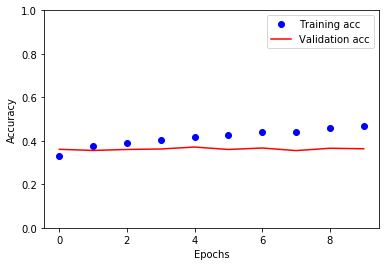

In [87]:
history = numerical_model.model.history
print(history.history.keys())

acc = history.history['acc']
val_acc = history.history['val_acc']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.legend()
plt.show()

## Union Model
Combining ImageFreeModel with TextOnlyModel using UnionModel

In [94]:
class UnionModel2(KaggleModel):
    def __init__(self, models, train, test, freeze=True):
        
        xs = []
        ys = []
        for model in models:
            model = model.model
            x = Input(shape=model.input_shape[1:], name='{}_in'.format(model.name))
            
            # Get the first layer of the model. This is the encoder
            layer = model.get_layer(index=0)
            
            # It must not be trainable
            if freeze: layer.trainable = False
            # The output only utilizes the encoder component
            y = layer(x)
            
            # Output should be flat
            if len(y.shape) > 2:
                y = Flatten()(y)
                
            # Save values
            xs.append(x)
            ys.append(y)

        y = Concatenate()(ys)

        y = Dense(128)(y)
        y = Dense(128)(y)
        y = Dense(128)(y)
        y = Dense(128)(y)
        y = Dense(128)(y)
        y = BatchNormalization()(y)

        y = Dense(5, activation='softmax')(y)
        
        model = Model(xs, y)

        super().__init__(model, train, test)

    def compile(self):
        self.model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [95]:
union_model = UnionModel2([text_model, numerical_model],
                         ([train_x_text, train_x_num], train_y),
                         ([valid_x_text, valid_x_num], valid_y))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
description_in (InputLayer)     (None, 30)           0                                            
__________________________________________________________________________________________________
image_free_in (InputLayer)      (None, 65)           0                                            
__________________________________________________________________________________________________
description_encoder (Sequential (None, 32)           829088      description_in[0][0]             
__________________________________________________________________________________________________
image_free_encoder (Sequential) (None, 32)           19044       image_free_in[0][0]              
__________________________________________________________________________________________________
concatenat

In [96]:
union_model.compile()
union_model.train(epochs=10)

Train on 10514 samples, validate on 2701 samples
Epoch 1/10
10514/10514 [==============================] - 11s 1ms/step - loss: 1.2753 - acc: 0.4664 - val_loss: 1.5986 - val_acc: 0.3528
Epoch 2/10
10514/10514 [==============================] - 6s 602us/step - loss: 1.2045 - acc: 0.4907 - val_loss: 1.6480 - val_acc: 0.3525
Epoch 3/10
10514/10514 [==============================] - 8s 720us/step - loss: 1.1961 - acc: 0.4905 - val_loss: 1.6738 - val_acc: 0.3554
Epoch 4/10
10514/10514 [==============================] - 7s 661us/step - loss: 1.1972 - acc: 0.4932 - val_loss: 1.6054 - val_acc: 0.3417
Epoch 5/10
10514/10514 [==============================] - 6s 593us/step - loss: 1.1929 - acc: 0.4902 - val_loss: 1.6120 - val_acc: 0.3340
Epoch 6/10
10514/10514 [==============================] - 7s 674us/step - loss: 1.1983 - acc: 0.4926 - val_loss: 1.5377 - val_acc: 0.3532
Epoch 7/10
10514/10514 [==============================] - 8s 762us/step - loss: 1.1900 - acc: 0.4932 - val_loss: 1.5670 - va

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


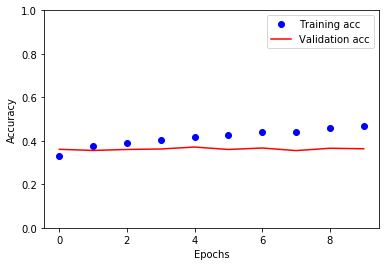

In [97]:
history = numerical_model.model.history
print(history.history.keys())

acc = history.history['acc']
val_acc = history.history['val_acc']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.legend()
plt.show()